In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("data/ligand-qsar/alkylamine-ligand-modeling.tsv", sep="\t")
df = df[df["product_1_yield"] > 15].reset_index(drop=True)

scaler = StandardScaler()
X = df.drop(columns=["ligand_1_name", "product_1_yield"])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_inv = pd.DataFrame(scaler.inverse_transform(X), columns=X.columns)

y = df["product_1_yield"]

In [ ]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_predict

sns.set_theme(rc={"figure.figsize": (5, 5), "figure.dpi": 150}, style="ticks", font_scale=1.2)


def evaluate_model(clf, X, y):
    """Evaluate a model using cross-validation."""
    clf.fit(X, y)
    print(X.columns)
    preds = clf.predict(X)
    r2 = metrics.r2_score(y, preds)
    rmse = metrics.root_mean_squared_error(y, preds)
    print(f"R^2: {r2:0.2f}")
    print(f"RMSE: {rmse:0.2f}")
    print()

    loo = LeaveOneOut()
    rmses = []
    maes = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        rmses.append(metrics.root_mean_squared_error(y_test, preds))
        maes.append(metrics.mean_absolute_error(y_test, preds))
    loo_rmse = round(np.mean(rmses), 2)
    loo_mae = round(np.mean(maes), 2)

    cv_preds = cross_val_predict(clf, X, y, cv=loo)
    loo_r2 = metrics.r2_score(y, cv_preds)

    print(f"LOO RMSE: {loo_rmse:0.2f}")
    print(f"LOO MAE: {loo_mae:0.2f}")
    print(f"LOO R^2: {loo_r2:0.2f}")
    print()

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    kfold_rmses = []
    kfold_maes = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
        kfold_maes.append(metrics.mean_absolute_error(y_test, preds))
    kfold_rmse = round(np.mean(kfold_rmses), 2)
    kfold_mae = round(np.mean(kfold_maes), 2)

    print(f"K-Fold RMSE: {kfold_rmse:0.2f}")
    print(f"K-Fold MAE: {kfold_mae:0.2f}")
    kfold_cv_preds = cross_val_predict(clf, X, y, cv=kfold)
    kfold_r2 = metrics.r2_score(y, kfold_cv_preds)
    print(f"K-Fold R^2: {kfold_r2:0.2f}")

    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.plot([0, 100], [0, 100], color="grey", linestyle="--")

    sns.scatterplot(x=y, y=cv_preds, s=200, ax=ax)
    ax.set_xlabel("Observed Yield (%)")
    ax.set_ylabel("Predicted Yield (%)")
    ax.set_title("Linear Regression of 'Active' Ligand Yields", pad=15)

    ax.text(
        5,
        95,
        f"LOO R$^2$: {loo_r2:.2f}\nLOO RMSE: {loo_rmse:.2f}\nLOO MAE: {loo_mae:.2f}",
        fontsize=12,
        color="black",
        ha="left",
        va="top",
        bbox=dict(
            facecolor="white",
            alpha=1.0,
            edgecolor="lightgrey",
            boxstyle="round,pad=0.5,rounding_size=0.2",
        ),
    )

    for i, txt in enumerate(df["ligand_1_name"]):
        ax.annotate(
            txt,
            (y[i], cv_preds[i]),
            fontsize=12,
            ha="right",
            va="bottom",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        )

    coefficients = sorted(zip(X.columns, clf.coef_), key=lambda x: abs(x[1]), reverse=True)

    textstr = "\n".join(
        (
            f"Feature 1: {coefficients[0][0]} ({coefficients[0][1]:.2f})",
            # f"Feature 2: {coefficients[1][0]} ({coefficients[1][1]:.2f})",
        )
    )

    ax.text(
        50,
        -18,
        textstr,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="center",
    )

    plt.show()

In [32]:
from itertools import combinations

from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

run = True


def evaluate_combination(features: tuple):
    """Evaluate a combination of features."""
    clf = LinearRegression()
    clf.fit(X[list(features)], y)
    preds = clf.predict(X[list(features)])
    r2 = round(metrics.r2_score(y, preds), 2)
    rmse = round(metrics.root_mean_squared_error(y, preds), 2)

    if r2 < 0.8:
        return (features, r2, rmse, 0, 0)

    kfold = LeaveOneOut()
    kfold_rmses = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train[list(features)], y_train)
        preds = clf.predict(X_test[list(features)])
        kfold_rmses.append(metrics.root_mean_squared_error(y_test, preds))
    kfold_rmse = round(np.mean(kfold_rmses), 2)

    cv_preds = cross_val_predict(clf, X[list(features)], y, cv=kfold)
    kfold_r2 = round(metrics.r2_score(y, cv_preds), 2)
    if kfold_r2 < 0:
        return (features, r2, rmse, 0, kfold_rmse)

    return (features, r2, rmse, kfold_r2, kfold_rmse)


combinations_list = list(combinations(X.columns, 2))

print(f"Number of combinations: {len(combinations_list)}")

if run:
    results = Parallel(n_jobs=-1)(delayed(evaluate_combination)(features) for features in tqdm(combinations_list))

    results = sorted(results, key=lambda x: x[3], reverse=True)
    for features, r2, rmse, kfold_r2, kfold_rmse in results[:10]:
        print(f"Features: {features}, R2: {r2}, RMSE: {rmse},  LOO R2: {kfold_r2}, LOO RMSE: {kfold_rmse}")

Number of combinations: 9730


100%|██████████| 9730/9730 [00:23<00:00, 422.41it/s] 


Features: ('fukui_f_minus_metal', 'min_fukui_f_minus_aryl_carbon'), R2: 0.99, RMSE: 1.78,  LOO R2: 0.98, LOO RMSE: 2.64
Features: ('min_partial_charge_carbon', 'min_fukui_f_minus_aryl_carbon'), R2: 0.98, RMSE: 3.39,  LOO R2: 0.96, LOO RMSE: 3.45
Features: ('fukui_f_plus_carb_o', 'min_partial_charge_carbonyl_oxygen'), R2: 0.98, RMSE: 3.18,  LOO R2: 0.95, LOO RMSE: 4.35
Features: ('partial_charge_carboxylic_oxygen', 'fukui_f_minus_carb_oh'), R2: 0.98, RMSE: 3.07,  LOO R2: 0.94, LOO RMSE: 4.96
Features: ('min_fukui_f_minus_metal', 'min_fukui_f_minus_aryl_carbon'), R2: 0.98, RMSE: 3.37,  LOO R2: 0.93, LOO RMSE: 5.29
Features: ('partial_charge_ipso_carbon', 'max_homo_lumo'), R2: 0.97, RMSE: 4.21,  LOO R2: 0.92, LOO RMSE: 5.63
Features: ('min_buried_volume_2.0A', 'max_fukui_f_minus_aryl_carbon'), R2: 0.96, RMSE: 4.62,  LOO R2: 0.92, LOO RMSE: 5.22
Features: ('min_buried_volume_3.5A', 'min_fukui_f_minus_avg_amine_proton'), R2: 0.98, RMSE: 3.05,  LOO R2: 0.92, LOO RMSE: 5.03
Features: ('min_fu

Index(['fukui_f_minus_metal', 'min_fukui_f_minus_aryl_carbon'], dtype='object')
R^2: 0.99
RMSE: 1.78

LOO RMSE: 2.64
LOO MAE: 2.64
LOO R^2: 0.98

K-Fold RMSE: 2.71
K-Fold MAE: 2.60
K-Fold R^2: 0.99


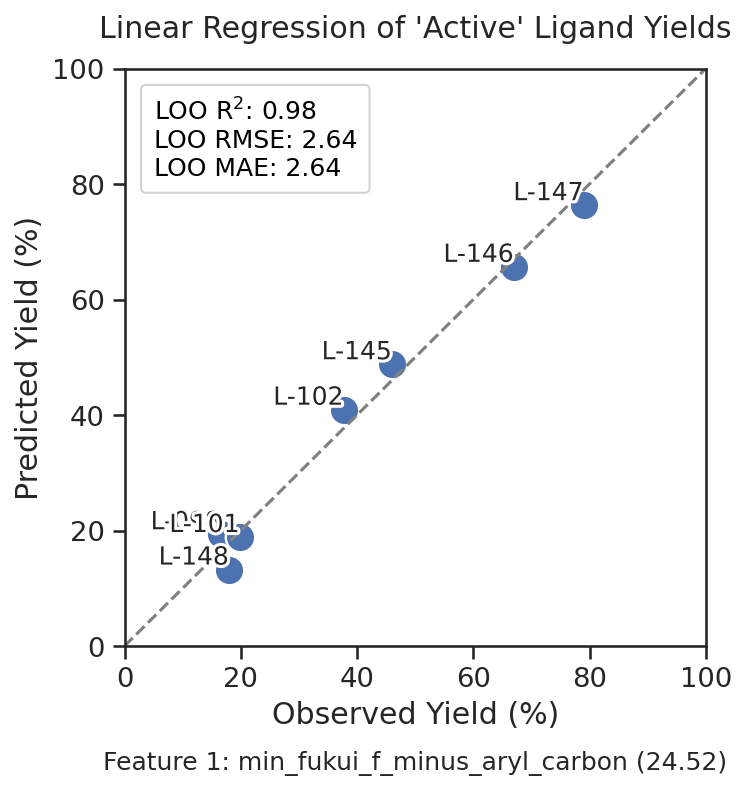

Feature coefficients:
  min_fukui_f_minus_aryl_carbon: 24.52
  fukui_f_minus_metal: 11.14


In [53]:
X_feat = X[list(results[0][0])]
clf = LinearRegression()
evaluate_model(clf, X_feat, y)

print("Feature coefficients:")
coefficients = sorted(zip(X_feat.columns, clf.coef_), key=lambda x: abs(x[1]), reverse=True)
for feature, coefficient in coefficients:
    print(f"  {feature}: {coefficient:0.2f}")

L-147


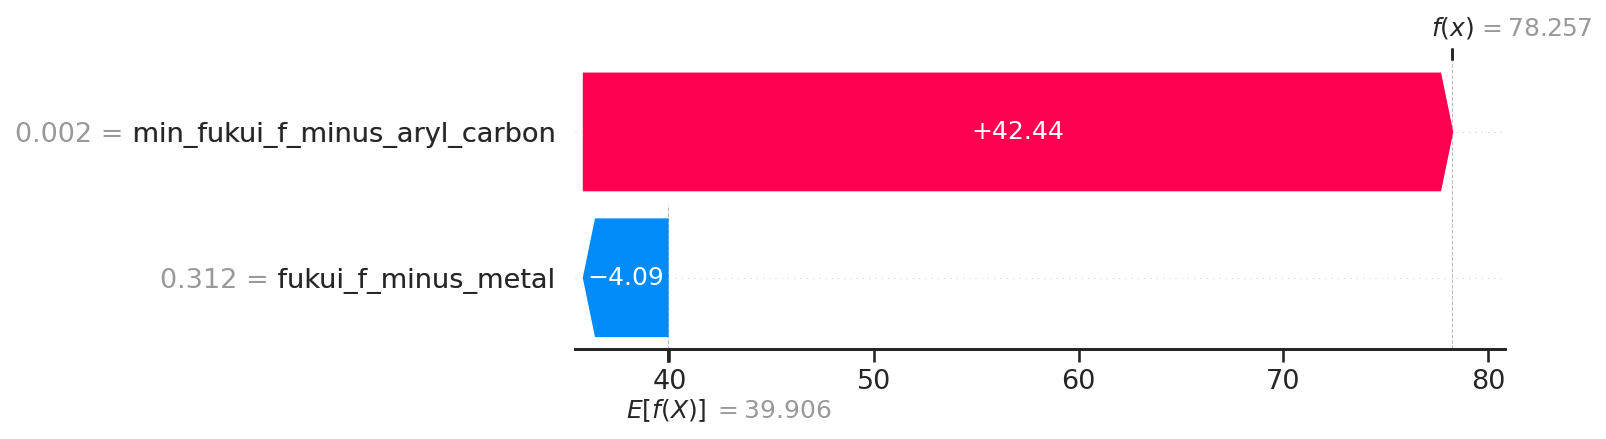

In [54]:
import shap

X_feat_inv = X_inv[list(results[0][0])]

explainer = shap.LinearExplainer(clf, X_feat)
shap_values = explainer(X_feat)
shap_values.data = X_feat_inv

print(df["ligand_1_name"].iloc[5])
shap.waterfall_plot(shap_values[5])

L-148


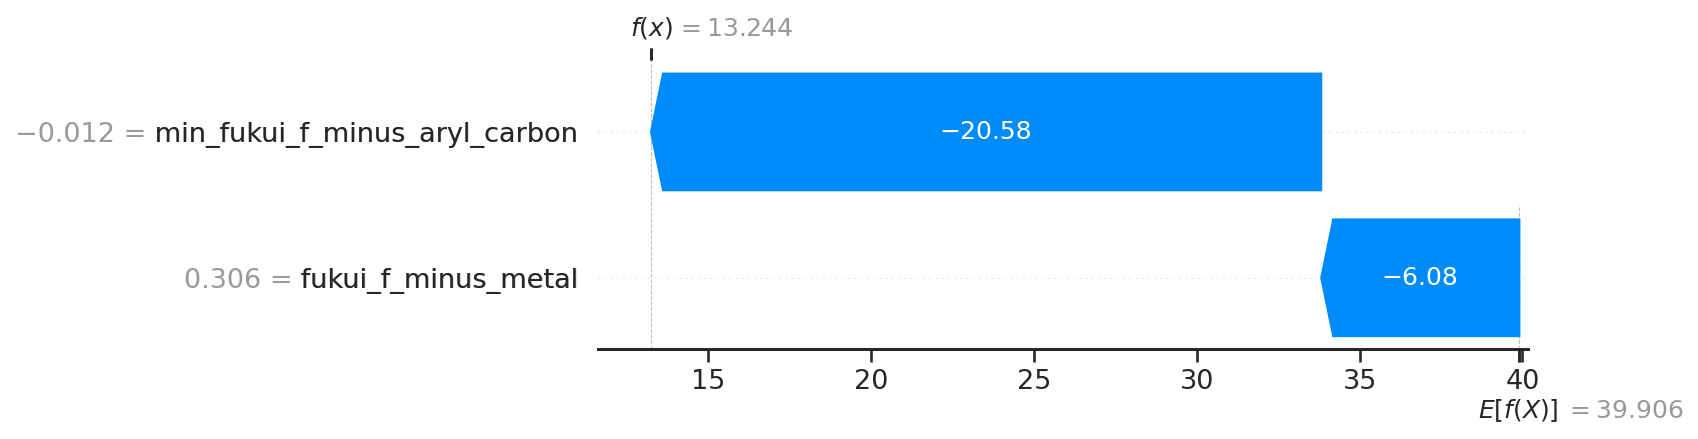

In [55]:
print(df["ligand_1_name"].iloc[6])
shap.waterfall_plot(shap_values[6])